In [1]:
import torch
import tqdm 
import torchvision
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
# torch random normal
from diffusers import UNet2DModel

The reverse process follows a markov chain with learned transitions.
$$p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right), \quad p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta\left(\mathbf{x}_t, t\right), \mathbf{\Sigma}_\theta\left(\mathbf{x}_t, t\right)\right)$$
The forward process is a markov chain that gradually adds noise.
$$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_0\right):=\prod_{t=1}^T q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right), \quad q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}\right)$$
We can sample in closed form like 
$$q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$$
Where $\alpha_t:=1-\beta_t$ and $\bar{\alpha}_t:=\prod_{s=1}^t \alpha_s$

First we are going to implement a forward noising function $q(x_t|x_0)$. I'll start by defining $\beta_t$. In the paper they use a linear noise scheduler, where $\beta_1 = 1e-4$ and $\beta_T=0.02$ where the total number of steps $T=1000$. From $\beta_t$ we can then define $\alpha_t$ and $\bar{\alpha}_t$. 

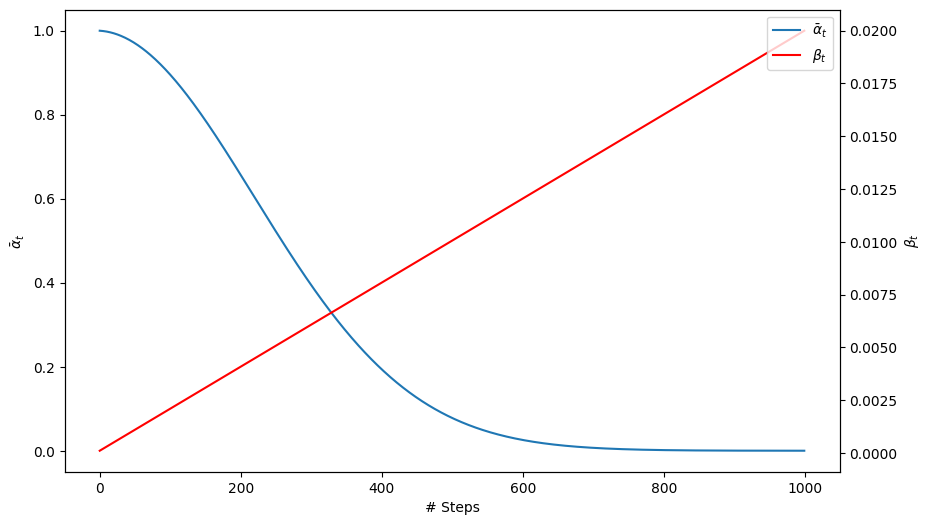

In [2]:
# Define constants
T = 1000
# Calculate beta_t and alpha_t
beta_t = np.linspace(1e-4, 0.02, T)
alpha_t = 1 - beta_t
# Calculate cumulative product of alpha_t
alpha_bar_t = np.cumprod(alpha_t)

# The rest of the code is just for plotting

plt.figure(figsize=(10, 6))
alpha_line, = plt.plot(alpha_bar_t, label=r'$\bar{\alpha}_t$')
plt.xlabel('# Steps')
plt.ylabel(r'$\bar{\alpha}_t$')
ax2 = plt.twinx()
beta_line, = plt.plot(beta_t, color='red', label=r'$\beta_t$')
plt.ylabel(r'$\beta_t$')
plt.legend(handles=[alpha_line, beta_line], labels=[r'$\bar{\alpha}_t$', r'$\beta_t$'], loc='upper right')
plt.show()

Recall that we can sample in closed form from $q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$. We see that $\alpha_T≈0$, for that we get $q\left(\mathbf{x}_T \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_T ; 0, \mathbf{I}\right)$, i.e. our initial noise is sampled from a standard normal distribtion. $q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)= \sqrt{\bar{\alpha}_t}\mathbf{x}_0+(1-\sqrt{\bar{\alpha}_t})\epsilon$, where $\epsilon \sim \mathcal{N}\left(0,1\right)$.

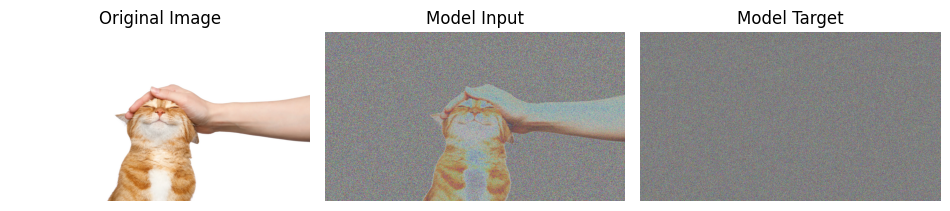

In [3]:
def forward_process(img, t):
    epsilon = torch.randn(img.size())
    sample = np.sqrt(alpha_bar_t[t])*img + np.sqrt(1-alpha_bar_t[t])*epsilon
    return {"img": sample, "target": epsilon, "t": t}

totensor = ToTensor()
# sample from normal distribution
t = 50
img = Image.open('cat.jpg')
img = totensor(img)
out = forward_process(img, t)
# Convert tensors to PIL images
topil = ToPILImage()
sample_pil = topil(out["img"])
target_pil = topil(out["target"])
img = topil(img)
# Create a figure with two subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the sample image
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
# Plot the sample image
ax[1].imshow(sample_pil)
ax[1].set_title('Model Input')
ax[1].axis('off')
# Plot the target image
ax[2].imshow(target_pil)
ax[2].set_title('Model Target')
ax[2].axis('off')
# Remove the space between subplots
plt.subplots_adjust(wspace=0.05)
# Show the plot
plt.show()

Here I use the MSE loss, which the paper found to be beneficial to sample quality and simpler to implement
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$
Where $t\in[1, T]$ is sampled uniformly from the range. To train the model we simply follow Algorithm 1 from the paper
$$
\begin{aligned}
&\text { Algorithm } 1 \text { Training }\\
&\text { repeat }\\
&\mathbf{x}_0 \sim q\left(\mathbf{x}_0\right)\\
&t \sim \operatorname{Uniform}(\{1, \ldots, T\})\\
&\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\
&\text { Take gradient descent step on }\\
&\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\\
&\text { until converged }
\end{aligned}
$$

We need a model $\boldsymbol{\epsilon}_\theta: (R^{C\times H \times W},t)\rightarrow R^{C\times H \times W}$. Here I use the Unet implemented in https://github.com/dome272/Diffusion-Models-pytorch. Which can be found in models/model.py. To implement the training procedure, I use pytorch lightning, which cuts down the need for boilerplate code. I start by defining the model, loss function, $T$, $\beta_{t}$, $\alpha_{t}$ and $\bar{\alpha}_t$. I also define a validation metric, namely the Frechet Inception Distance, which measures the difference in real and generated distributions in a pretrained InceptionV3 encoders latent space, assuming that these features are normally distributed.

In [4]:
import torchmetrics
import pytorch_lightning as pl
from models.model import UNet


class DiffModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model =  UNet(device=self.device)
        self.loss_fn = torch.nn.MSELoss()
        self.e = 0
        self.metric = torchmetrics.image.fid.FrechetInceptionDistance()
        self.T = 500
        self.beta_t = torch.linspace(1e-4, 0.02, self.T).to(self.device)
        self.alpha_t = 1 - self.beta_t
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0)

Now I define the the forward noising function, unlike before I now need the function to operate on batches of images rather than just a single image, this is simple to implement using broadcasting. 

In [5]:
def forward_process(self, img):
    t = torch.randint(0, self.T, size=(img.shape[0],)).to(self.device)
    epsilon = torch.randn(img.size()).to(self.device)
    sample = (torch.sqrt(self.alpha_bar_t[t, None, None, None]) * img +
              torch.sqrt(1 - self.alpha_bar_t[t, None, None, None]) * epsilon)
    return {"img": sample, "target": epsilon, "t": t}

DiffModel.forward_process = forward_process

Now we define the training step

In [6]:
def training_step(self, batch, batch_idx):
    out = self.forward_process(batch)
    x, y, t = out["img"], out["target"], out["t"]
    y_hat = self(x, t)
    loss = self.loss_fn(y_hat, y)
    self.log("train_loss", loss)
    return loss # lightning will automatically optimize this loss i.e. zero_grad, backward, step

DiffModel.training_step = training_step

def forward(self, x, t):
    return self.model(x, t)

DiffModel.forward = forward

Now we are ready to train the model, but we haven't yet implemented how to generate images. 

Algorithm 2 Sampling
$$
\begin{aligned}
& \text { 1: } \mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
& \text { 2: for } t=T, \ldots, 1 \text { do } \\
& \text { 3: } \mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \text { if } t>1, \text { else } \mathbf{z}=\mathbf{0} \\
& \text { 4: } \mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z} \\
& \text { 5: end for } \\
& \text { 6: return } \mathbf{x}_0
\end{aligned}
$$

In [7]:
def sample_step(self, x, t):
    eps_theta = self(x, t)
    z = torch.randn(x.size()).to(self.device)
    x = (1 / torch.sqrt(self.alpha[t])) * (x - ((1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_bar[t])) * eps_theta) + torch.sqrt(self.beta[t]) * z
    return x

def sample(self, viz=False):
    self.T = 500
    self.beta = torch.linspace(1e-4, 0.02, self.T)
    self.alpha = 1 - self.beta
    self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    x = torch.randn(256, 3, 16, 16).to(self.device)
    
    for t in range(self.T-1, 0, -1):
        x = self.sample_step(x, torch.tensor(t).to(self.device))
    
    if viz:
        x_img = torchvision.utils.make_grid(x[:10], nrow=10)
        x_img = ToPILImage()(x_img)
        x_img.save(f"generated_data/sample{self.e+1}.png")
        self.e += 1
        
    return x


DiffModel.sample_step = sample_step
DiffModel.sample = sample


Now we can implement the validation step, here we sample a batch of real images, and synthetic images and calculate the FID. Note that torchmetrics is integrated with lightning, meaning that it automatically implements .compute and .reset on the metric at the end of an epoch, and logs these values.
Finally we define the optimizer.

In [8]:
def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

DiffModel.configure_optimizers = configure_optimizers

In [10]:
from torchvision.transforms import ToTensor, ToPILImage
from dataset.sprites_dataset import SpritesDataset

dataset = SpritesDataset(ToTensor(), seed=0)
#breakpoint()
# split into train and test
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
# define dataloader
dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=3
)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False, num_workers=3
)
print(len(dataloader), len(val_dataloader))

model = DiffModel()
trainer = pl.Trainer(
    logger= pl.loggers.wandb.WandbLogger(),
    accelerator="cpu",
    devices=1,
    max_epochs=100,
    callbacks=[pl.callbacks.ModelCheckpoint(
        monitor="fid",
        mode="min",
        save_top_k=1,
    )],
    limit_val_batches=1
)  
trainer.fit(model, dataloader, val_dataloader)

Dataset shape: (40000, 16, 16, 3)
149 8


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/ADLCV/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
/opt/homebrew/Caskroom/miniconda/base/envs/ADLCV/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/opt/homebrew/Caskroom/miniconda/base/envs/ADLCV/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name    | Type                     | Params
---

Training: |          | 0/? [00:00<?, ?it/s]

Now the model is ready to train and generate images. We use the sprites dataset.

Epoch 1:
![generated_data/sample1.png](generated_data/sample1.png)

epoch 10:
![generated_data/sample10.png](generated_data/sample10.png)

epoch 20:
![generated_data/sample20.png](generated_data/sample20.png)

epoch 30:
![generated_data/sample30.png](generated_data/sample30.png)

epoch 40:
![generated_data/sample30.png](generated_data/sample40.png)

epoch 50:
![generated_data/sample50.png](generated_data/sample50.png)

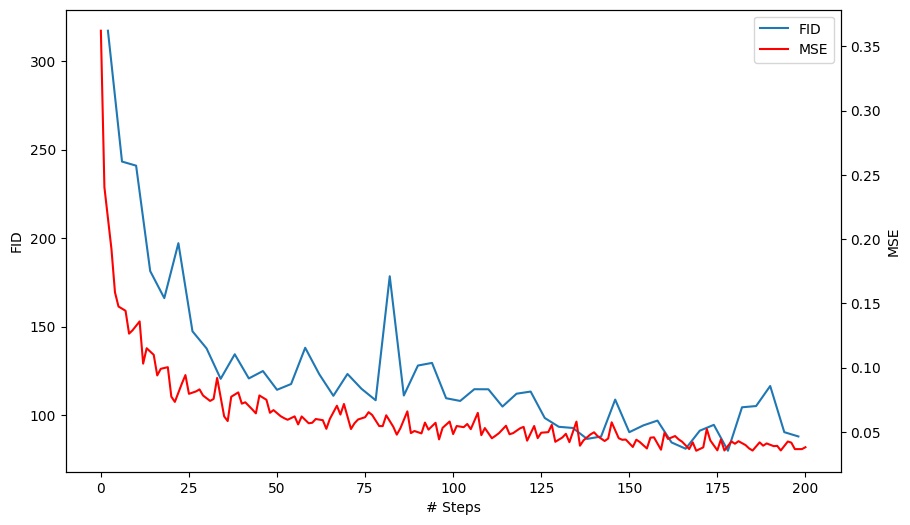

In [45]:
import pandas as pd
path2fid = "wandb_export_2024-06-26T13_40_51.571+02_00.csv"
path2loss = "wandb_export_2024-06-26T13_40_58.870+02_00.csv"

fid = pd.read_csv(path2fid)
fid_step = fid["Step"]
fid = fid["silvery-pyramid-33 - fid"]

loss = pd.read_csv(path2loss)
#train_loss = losses["train_loss"]
loss_step = loss["Step"]
loss = loss["silvery-pyramid-33 - train_loss"]

plt.figure(figsize=(10, 6))
alpha_line, = plt.plot(fid_step, fid, label=r'FID')
plt.xlabel('# Steps')
plt.ylabel(r'FID')
ax2 = plt.twinx()
beta_line, = plt.plot(loss_step, loss, color='red', label=r'MSE')
plt.ylabel(r'MSE')
plt.legend(handles=[alpha_line, beta_line], labels=[r'FID', r'MSE'], loc='upper right')
plt.show()

